In [ ]:
!pip install underthesea

In [ ]:
# --- CELL 1: SETUP DỮ LIỆU ---
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from underthesea import word_tokenize, text_normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import time

# 1. Đường dẫn Github
TRAIN_PATH = 'https://raw.githubusercontent.com/Vietnam-NLI-Project/vietnam-nli-project/refs/heads/main/data/train.csv'
VAL_PATH   = 'https://raw.githubusercontent.com/Vietnam-NLI-Project/vietnam-nli-project/refs/heads/main/data/dev.csv'
TEST_PATH  = 'https://raw.githubusercontent.com/Vietnam-NLI-Project/vietnam-nli-project/refs/heads/main/data/test.csv'
AUG_PATH   = 'https://raw.githubusercontent.com/Vietnam-NLI-Project/vietnam-nli-project/refs/heads/main/data/train_augmented.csv'

# 2. Đọc dữ liệu
print("Đang đọc dữ liệu...")
train_df = pd.read_csv(TRAIN_PATH)
val_df = pd.read_csv(VAL_PATH)
test_df = pd.read_csv(TEST_PATH)
aug_df = pd.read_csv(AUG_PATH)

# Lấy các cột cần thiết
FEATURE_COLS = ['Premise', 'Hypothesis', 'Label']
train_df = train_df[FEATURE_COLS]
val_df = val_df[FEATURE_COLS]
test_df = test_df[FEATURE_COLS]
aug_df = aug_df[FEATURE_COLS]

# Gộp data gốc và data làm giàu
train_df = pd.concat([train_df, aug_df], ignore_index=True)
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# 3. Hàm chuẩn hóa (Như code cũ của bạn)
def Standardize_sent(text):
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r"\.$", "", text)
    text = text.strip()
    text = text_normalize(text)
    text = word_tokenize(text, format='text')
    return text


print("Đang tiền xử lý văn bản...")
for df in [train_df, val_df, test_df]:
    df['Premise'] = df['Premise'].fillna("").apply(Standardize_sent)
    df['Hypothesis'] = df['Hypothesis'].fillna("").apply(Standardize_sent)
    # Tạo cột đầu vào
    df['Sent_input'] = df['Premise'] + ' [SEP] ' + df['Hypothesis']

print("Cell 1 hoàn tất! Dữ liệu đã sẵn sàng.")

In [ ]:
# --- CELL 2: THIẾT LẬP PREDEFINED SPLIT ---

# 1. Gộp Train và Dev thành một tập lớn
X_full_text = pd.concat([train_df['Sent_input'], val_df['Sent_input']], ignore_index=True)
y_full_label = pd.concat([train_df['Label'], val_df['Label']], ignore_index=True)

# 2. Tạo chỉ mục đánh dấu

split_index = [-1]*len(train_df) + [0]*len(val_df)

# 3. Khởi tạo đối tượng PredefinedSplit
pds = PredefinedSplit(test_fold=split_index)


print(f"Tổng số mẫu gộp: {len(X_full_text)}")
print(f"Số mẫu Train: {len(train_df)}")
print(f"Số mẫu Dev (Validation): {len(val_df)}")

In [ ]:
# --- CELL 3: TÌM THAM SỐ ---
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, PredefinedSplit
import time

# 1. SETUP DỮ LIỆU
# Gộp train và dev
X_full_text = pd.concat([train_df['Sent_input'], val_df['Sent_input']], ignore_index=True)
y_full_label = pd.concat([train_df['Label'], val_df['Label']], ignore_index=True)

# Tạo chỉ mục PredefinedSplit (-1: Train, 0: Dev)
split_index = [-1]*len(train_df) + [0]*len(val_df)
pds = PredefinedSplit(test_fold=split_index)

# 2. THIẾT LẬP PIPELINE
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
    ('svm', SVC(random_state=42))
])

# 3. THIẾT LẬP KHÔNG GIAN TÌM KIẾM (PARAM GRID)
param_grid = [
    # --- NHÓM 1: LINEAR ---
    {
        'svm__kernel': ['linear'],
        'svm__C': [1, 10, 20, 50, 100],
        'tfidf__max_features': [500, 1000, 1500, 2000, 2500, 3000, 5000, 6500, 10000, 15000, 16000, 17000, 18000, None]
    },

    # --- NHÓM 2: RBF ---
    {
        'svm__kernel': ['rbf'],
        'svm__C': [1, 10],
        'svm__gamma': ['scale', 0.1],
        'tfidf__max_features': [500, 1000, 1500, 2000, 2500, 3000, 5000, 6500, 10000, 15000, 16000, 17000, 18000, None]

    }
]

print("Đang chạy...")
start = time.time()


grid_final = GridSearchCV(
    pipeline,
    param_grid,
    cv=pds,
    scoring='f1_macro',
    verbose=1,
    n_jobs=2
)

grid_final.fit(X_full_text, y_full_label)

print(f"\nTổng thời gian: {time.time() - start:.2f}s")
print("-" * 50)
print(f"CẤU HÌNH TỐT NHẤT: {grid_final.best_params_}")
print(f"ĐIỂM SỐ CAO NHẤT (DEV): {grid_final.best_score_:.4f}")
print("-" * 50)

# --- 4. BẢNG XẾP HẠNG ---
results = pd.DataFrame(grid_final.cv_results_)
# Lọc cột cần thiết
cols = ['param_svm__kernel', 'param_tfidf__max_features', 'param_svm__C', 'mean_test_score', 'mean_fit_time']
results['param_tfidf__max_features'] = results['param_tfidf__max_features'].fillna('All')

# Sắp xếp để tìm ra Best của từng Kernel
print("\nTOP 5 CẤU HÌNH TỐT NHẤT:")
print(results[cols].sort_values(by='mean_test_score', ascending=False).head(5))

print("\n--- SO SÁNH ---")
# Lấy điểm cao nhất của Linear
best_linear = results[results['param_svm__kernel'] == 'linear']['mean_test_score'].max()
print(f"Linear mạnh nhất đạt: {best_linear:.4f}")

# Lấy điểm cao nhất của RBF
best_rbf = results[results['param_svm__kernel'] == 'rbf']['mean_test_score'].max()
print(f"RBF mạnh nhất đạt:    {best_rbf:.4f}")


### SVM Validation Results
- Best RBF kernel **F1-score**: **0.5138**
- Best Linear kernel **F1-score**: **0.4811**

**Best hyperparameters (GridSearchCV):**
```python
{
  'svm__C': 10,
  'svm__gamma': 'scale',
  'svm__kernel': 'rbf',
  'tfidf__max_features': 500
}


Đang huấn luyện mô hình RBF (C=10, Feat=500) trên 2139 mẫu...

--- KẾT QUẢ CUỐI CÙNG TRÊN TẬP TEST ---
              precision    recall  f1-score   support

           0     0.4375    0.3000    0.3559        70
           1     0.4737    0.5000    0.4865        72
           2     0.4719    0.5915    0.5250        71

    accuracy                         0.4648       213
   macro avg     0.4610    0.4638    0.4558       213
weighted avg     0.4612    0.4648    0.4564       213



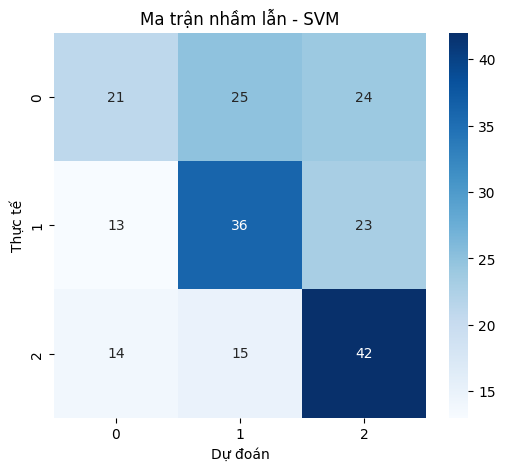

In [6]:
# --- CELL ĐÁNH GIÁ---
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC # Dùng SVC cho RBF
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Cấu hình mô hình RBF từ GridSearch

final_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=500)),
    ('svm', SVC(kernel='rbf', C=10, random_state=42))
])

# 2. Huấn luyện lại trên TOÀN BỘ dữ liệu (Train + Dev)

X_full_text = pd.concat([train_df['Sent_input'], val_df['Sent_input']], ignore_index=True)
y_full_label = pd.concat([train_df['Label'], val_df['Label']], ignore_index=True)

print(f"Đang huấn luyện mô hình RBF (C=10, Feat=500) trên {len(X_full_text)} mẫu...")
final_pipeline.fit(X_full_text, y_full_label)

# 3. Đánh giá trên tập Test
print("\n--- KẾT QUẢ CUỐI CÙNG TRÊN TẬP TEST ---")
y_test_pred = final_pipeline.predict(test_df['Sent_input'])

print(classification_report(test_df['Label'], y_test_pred, digits=4))

# Vẽ Confusion Matrix
cm = confusion_matrix(test_df['Label'], y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.title('Ma trận nhầm lẫn - SVM')
plt.ylabel('Thực tế')
plt.xlabel('Dự đoán')
plt.show()